<a href="https://colab.research.google.com/github/EAkeweje/GEOMETRIC-LEARNING-FOR-FLOWS-IN-POROUS-SYSTEMS/blob/main/Non-linear%20SNDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Ignore this cell. 
#for access to data files
%cd /content/drive/MyDrive/Skoltech/Research/GDL

/content/drive/MyDrive/Skoltech/Research/GDL


In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary
import PIL
import pandas as pd
from statsmodels.nonparametric.kernel_regression import KernelReg
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import copy
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#####custom functions########
import sys
import os
sys.path.append(os.getcwd()+'/scripts')

import utils
from NWR import triangle_density, NW_reg, Graph_NW_reg

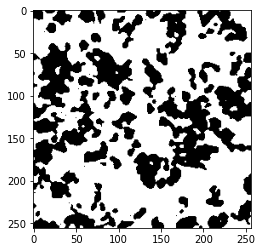

In [6]:
##visualization of pore system
'''
Change directory to any pore image. The function, gen_pore_array, converts the pore image to pore array.
If you choose to use a pore array then use
pore_array = 'path_to_pore array'
'''
pore_array = utils.gen_pore_array("./Dataset/Fluid Flow Simulation/1.png")
plt.imshow(pore_array,'binary')

## The custom fluid dataset object

In [7]:
class FluidDataset(Dataset):
    """Fluid in porous media dataset."""

    def __init__(self, img_path, root_dir, ks, gauge):
        """
        Args:
            img_path (string): Path to the porous structure image.
            root_dir (string): Directory with all the velocity data.
            ks (int): coarse graining grid size. If no coarse graining is required, set ks to 1
            gauge (int): number of sensors
        """
        self.img_path = img_path
        self.ks = ks
        self.root_dir = root_dir
        self.gauge = gauge

        ##get pore image array
        an_image = PIL.Image.open(self.img_path)
        image_sequence = an_image.getdata()
        image_array = np.array(image_sequence)/255
        k = np.asarray(an_image)[:,:,0]/255
        #adjustment so that the pore spaces are mapped to 0 and the solid immovable parts mapped to 1
        self.pore_array = np.ones_like(k) - k
        #get list velocity data
        self.vel_data = sorted(glob.glob(self.root_dir+'/*.dat'))
        ##coarse grain the system
        self.CG_array = utils.coarse_grain(np.rot90(self.pore_array), self.ks)
        #'install' sensors at pore walls... get the wall boundaries
        #To condition same condition as that used for the graphing image
        CG_array = np.where(self.CG_array <= self.ks**2/2, 0, 1)
        #get total space from working array
        self.total_space = utils.get_total_space(CG_array)
        boundary_points = utils.get_bounds(1-CG_array)
        #random select gauge spots
        random.seed(42)
        self.guage_space = random.sample(boundary_points, self.gauge)
        self.no_guage_space = copy.deepcopy(self.total_space)
        dup_sensor = list()
        for b_ in self.guage_space:
          try:
            self.no_guage_space.remove(b_)
          except:
            dup_sensor.append(b_)
            # print(f'Warning! {b_} seems to be a duplicate sensory position')
        for b_ in dup_sensor:
          self.guage_space.remove(b_)

    def __len__(self):
        return len(self.vel_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #get velocity field data
        f = np.loadtxt(self.vel_data[idx])
        f = np.reshape(f,(256,256,2))
        f = np.rot90(f)
        #coarse graining velocity data
        CG_f_0 = utils.coarse_grain(f[:,:,0],self.ks)/(self.ks*self.ks)
        CG_f_1 = utils.coarse_grain(f[:,:,1],self.ks)/(self.ks*self.ks)
        #partitions velocity data
        vel_x_ngs = [CG_f_0[i] for i in self.no_guage_space] #velocity (x-dimension) at no sensor
        vel_y_ngs = [CG_f_1[i] for i in self.no_guage_space] #velocity (y-dimension) at no sensor
        vel_x_gs = [CG_f_0[i] for i in self.guage_space] #velocity (x-dimension) from sensor
        vel_y_gs = [CG_f_1[i] for i in self.guage_space] #velocity (y-dimension) from sensor
        
        return torch.tensor([vel_x_gs,vel_y_gs]), torch.tensor([vel_x_ngs,vel_y_ngs]) #returns sensor data (tensor), no sensor data (tensor)

## The network

Two non-linear SND architectures were considered: Shared-decoder and Separated-decoder



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#The Shared-decoder architecture
class netv2(nn.Module):
  def __init__(self, num_gauges,hidn1, hidn2, num_no_gauge):
    super(netv2, self).__init__()
    self.layers = nn.Sequential(nn.Linear(num_gauges, hidn1),
                              nn.Tanh(),
                              # nn.BatchNorm1d(hidn1),
                              nn.Dropout(0.2),
                              nn.Linear(hidn1, hidn2),
                              nn.Tanh(),
                              #nn.BatchNorm1d(hidn2),
                              nn.Linear(hidn2, num_no_gauge)
        )

  def forward(self, x):
    return self.layers(x)

#The Separated-decoder architecture
class sep_net(nn.Module):
  def __init__(self, num_gauges,hidn1, hidn2, num_no_gauge):
    super(sep_net, self).__init__()
    self.dimx = nn.Sequential(nn.Linear(num_gauges, hidn1),
                              nn.Tanh(),
                              # nn.BatchNorm1d(hidn1),
                              nn.Dropout(0.2),
                              nn.Linear(hidn1, hidn2),
                              nn.Tanh(),
                              #nn.BatchNorm1d(hidn2),
                              nn.Linear(hidn2, num_no_gauge)
        )
    self.dimy = nn.Sequential(nn.Linear(num_gauges, hidn1),
                              nn.Tanh(),
                              # nn.BatchNorm1d(hidn1),
                              nn.Dropout(0.2),
                              nn.Linear(hidn1, hidn2),
                              nn.Tanh(),
                              # nn.BatchNorm1d(hidn2),
                              nn.Linear(hidn2, num_no_gauge)
        )

  def forward(self, x):
      #separate x from y
      x, y = x[:,0,:], x[:,1,:]
      #pass data through network
      x = self.dimx(x)
      y = self.dimy(y)
      #return stacked tensor
      return torch.stack([x,y], dim=1)

## Data loading

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating Training and Validation loaders
'''
Adapted this code for test and train split
'''
batch_size = 16
dataset = FluidDataset(img_path="./Dataset/Fluid Flow Simulation/1.png",
                       root_dir = "./Dataset/Fluid Flow Simulation",
                       ks=2, gauge=10)
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.3
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

## Model configuration

In [11]:
#the model
input_size = len(dataset.guage_space)
output_size = len(dataset.no_guage_space)
'''
Either the shared-decoder or separated-decoder architectures could be implemented.
To implement shared decoder nonlinear SNDs, use netv2 model
To implement separeted decoder nonlinear SNDs, use sep_net model
'''
model = netv2(input_size,200,500,output_size)

In [12]:
summary(model, (batch_size,2,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
netv2                                    [16, 2, 10686]            --
├─Sequential: 1-1                        [16, 2, 10686]            --
│    └─Linear: 2-1                       [16, 2, 200]              2,200
│    └─Tanh: 2-2                         [16, 2, 200]              --
│    └─Dropout: 2-3                      [16, 2, 200]              --
│    └─Linear: 2-4                       [16, 2, 500]              100,500
│    └─Tanh: 2-5                         [16, 2, 500]              --
│    └─Linear: 2-6                       [16, 2, 10686]            5,353,686
Total params: 5,456,386
Trainable params: 5,456,386
Non-trainable params: 0
Total mult-adds (M): 87.30
Input size (MB): 0.00
Forward/backward pass size (MB): 2.91
Params size (MB): 21.83
Estimated Total Size (MB): 24.74

## Model training

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    model = model.cuda()
 
# Declaring Criterion and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)#, betas=(0.9, 0.95), weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training with Validation
epochs = 400
min_valid_loss = np.inf
train_loss = []
valid_loss = []

for e in range(epochs):
    train_loss_ = 0.0
    model.train()
    for input, output in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss_ += loss.item()
     
    valid_loss_ = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for input, output in validation_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate Loss
        valid_loss_ += loss.item()
    
    scheduler.step()

    if (e+1)%10 == 0:
      print(f'Epoch {e+1} \t\t Training Loss: {train_loss_ / len(train_loader)} \t\t Validation Loss: {valid_loss_ / len(validation_loader)}')

    train_loss.append(train_loss_ / len(train_loader))
    valid_loss.append(valid_loss_ / len(validation_loader))
     
    if min_valid_loss > valid_loss_:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss_:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss_
         
        # Saving State Dict
        torch.save(model.state_dict(), f'./Models/netv2_3hidlay_{len(dataset.guage_space)}sensors_tanh_noNorm_5step_train.pth')

Validation Loss Decreased(inf--->0.009681) 	 Saving The Model
Validation Loss Decreased(0.009681--->0.002176) 	 Saving The Model
Validation Loss Decreased(0.002176--->0.000396) 	 Saving The Model
Validation Loss Decreased(0.000396--->0.000147) 	 Saving The Model
Validation Loss Decreased(0.000147--->0.000072) 	 Saving The Model
Validation Loss Decreased(0.000072--->0.000066) 	 Saving The Model
Validation Loss Decreased(0.000066--->0.000049) 	 Saving The Model
Validation Loss Decreased(0.000049--->0.000041) 	 Saving The Model
Epoch 10 		 Training Loss: 0.00011331859111253704 		 Validation Loss: 6.5530577254927875e-06
Validation Loss Decreased(0.000041--->0.000039) 	 Saving The Model
Validation Loss Decreased(0.000039--->0.000037) 	 Saving The Model
Validation Loss Decreased(0.000037--->0.000037) 	 Saving The Model
Validation Loss Decreased(0.000037--->0.000034) 	 Saving The Model
Validation Loss Decreased(0.000034--->0.000034) 	 Saving The Model
Validation Loss Decreased(0.000034--->0.0

Text(0, 0.5, 'MSE')

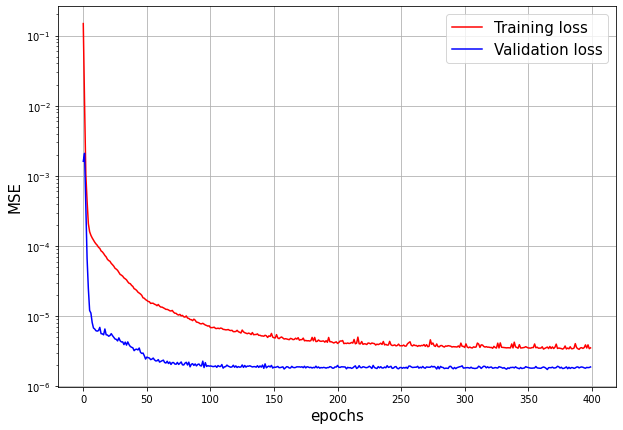

In [ ]:
#visualize training history
plt.figure(figsize = (10,7))
epochs = len(train_loss)
plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
plt.plot(range(epochs),valid_loss,'-b',label = 'Validation loss')
plt.yscale('log')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
# plt.title(f'Loss curve (2ks {input_size} sensor)', fontsize = 20)
# plt.savefig(f'./Models/2SD_2x2CG_{input_size}sensors_norelu_withNorm.pdf')

In [ ]:
#save training history
fcmodel_2x2CG_996sensors_losses = {'train_loss': train_loss, 'val_loss': valid_loss}
a_file = open(f'./Models/netv2_losses_3hidlay_{len(dataset.guage_space)}sensors_tanh_noNorm_5step.json', "w")
json.dump(fcmodel_2x2CG_996sensors_losses, a_file)
a_file.close()

## Inference and visualization of results

In [13]:
chkpt = f'./Models/netv2_3hidlay_{len(dataset.guage_space)}sensors_tanh_noNorm_5step.pth'
model.load_state_dict(torch.load(chkpt,map_location=torch.device('cpu')))
if torch.cuda.is_available():
  model = model.cuda()

model.eval()

netv2(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=200, out_features=500, bias=True)
    (4): Tanh()
    (5): Linear(in_features=500, out_features=10686, bias=True)
  )
)

In [14]:
batch = next(iter(validation_loader))

In [15]:
x, y = batch
x.shape

torch.Size([16, 2, 10])

Visualization of results :)


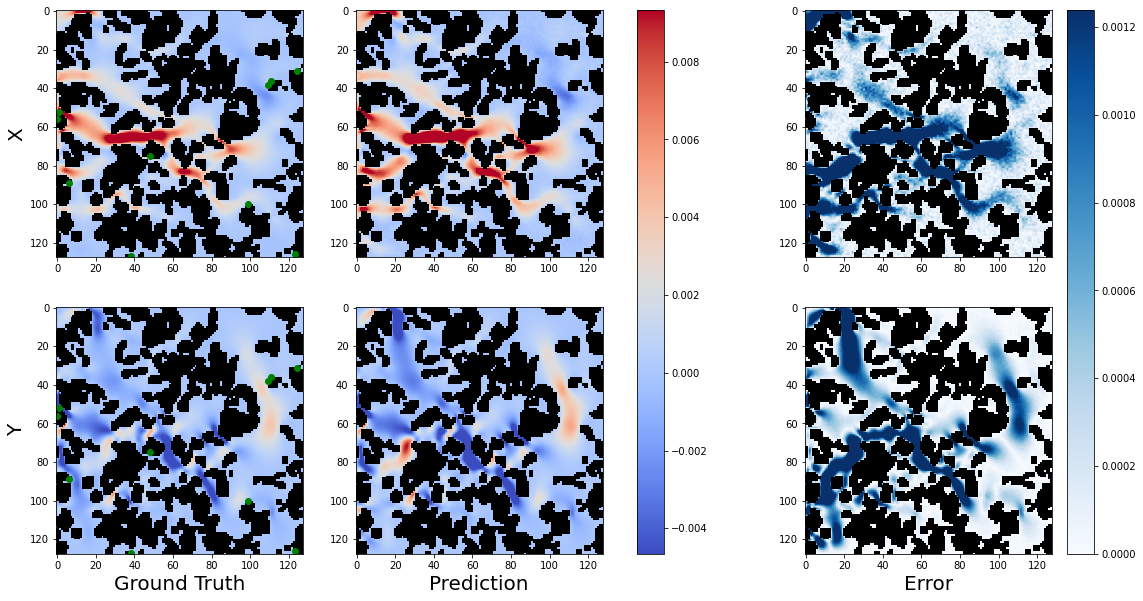

In [17]:
iii = 10

if torch.cuda.is_available():
    x, y = x.cuda(), y.cuda()


# for iii in [4,10,22]:
pr = model(x)[iii]
input_t = x[iii]
output_t = y[iii]
err_t = torch.abs(output_t - pr)

s = 128
pred_f_0 = np.zeros((s,s))
pred_f_1 = np.zeros((s,s))
pred_f_0[:,:]= np.nan; pred_f_1[:,:] = np.nan
orig_f_0 = np.zeros((s,s))
orig_f_1 = np.zeros((s,s))
orig_f_0[:,:]= np.nan; orig_f_1[:,:] = np.nan
g_f_0 = np.zeros((s,s))
g_f_1 = np.zeros((s,s))
g_f_0[:,:]= np.nan; g_f_1[:,:] = np.nan

for i,ind in enumerate(dataset.no_guage_space):
  pred_f_0[ind] = pr[0,i].item()
  pred_f_1[ind] = pr[1,i].item()
  orig_f_0[ind] = output_t[0,i].item()
  orig_f_1[ind] = output_t[1,i].item()
  g_f_0[ind] = err_t[0,i]
  g_f_1[ind] = err_t[1,i]

for i,ind in enumerate(dataset.guage_space):
  g_f_0[ind] = 0#input_t[0,i].item()
  g_f_1[ind] = 0#input_t[1,i].item()
  pred_f_0[ind] = input_t[0,i].item()
  pred_f_1[ind] = input_t[1,i].item()
  orig_f_0[ind] = input_t[0,i].item()
  orig_f_1[ind] = input_t[1,i].item()

#visualization
print('Visualization of results :)')
fig, ax = plt.subplots(2,3,figsize = (19,10))
#my porousing secret :(
for i in range(3):
    ax[0,i].set_facecolor((0., 0., 0.))
    ax[1,i].set_facecolor((0., 0., 0.))
ax[0,0].set_ylabel('X', fontsize = 20)
ax[1,0].set_ylabel('Y', fontsize = 20)

a = np.nanmin(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/5;
b = np.nanmax(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/3;
ax[0,0].imshow(orig_f_0, cmap='coolwarm',vmin = a, vmax =b);
ax[1,0].imshow(orig_f_1, cmap='coolwarm',vmin = a, vmax =b);
ax[0,1].imshow(pred_f_0, cmap='coolwarm',vmin = a, vmax =b);
im = ax[1,1].imshow(pred_f_1, cmap='coolwarm',vmin = a, vmax =b);

a = 0#np.nanmin(np.vstack([g_f_0,g_f_1]))/3;
b = np.nanmax(np.vstack([g_f_0,g_f_1]))/10
ax[0,2].imshow(g_f_0, cmap='Blues',vmin = a, vmax =b);
im1 = ax[1,2].imshow(g_f_1, cmap='Blues', vmin = a, vmax = b);

#get guages
g0,g1 = np.array(dataset.guage_space).T
ax[0,0].scatter(g1,g0,color='green',alpha=1)
ax[1,0].scatter(g1,g0,color='green',alpha=1)

# ax[0,0].set_title(f'Model Trained with {len(guage_space)} sensors',fontsize = 35)
ax[1,0].set_xlabel('Ground Truth', fontsize=20)
ax[1,2].set_xlabel('Error', fontsize=20)
ax[1,1].set_xlabel('Prediction', fontsize=20)
# plt.colorbar(im,ax = ax.ravel().tolist())
plt.colorbar(im,ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]])
plt.colorbar(im1,ax = [ax[0,2],ax[1,2]])
# plt.savefig(f"./Models/{chkpt[chkpt.rfind('/')+1:chkpt.rfind('.')]}.pdf")

# Evaluation of performance

In [18]:
##NME
for i, (x,y) in enumerate(validation_loader):
  if torch.cuda.is_available():
      input, output = x.cuda(), y.cuda()
  else:
      input, output = x.cpu(), y.cpu()
  if i == 0:
    output_stack = output
    pred_stack = model(input.float())
  else:
    output_stack = torch.cat([output_stack,output])
    pred_stack = torch.cat([pred_stack,model(input.float())])
  # print(output_stack.shape, pred_stack.shape)
error = torch.linalg.norm(output_stack - pred_stack)/torch.linalg.norm(output_stack)
print(f'Normalized Error: {error}')

Normalized Error: 0.5013161897659302


In [19]:
"""
https://stackoverflow.com/questions/65840698/how-to-make-r2-score-in-nn-lstm-pytorch
From https://en.wikipedia.org/wiki/Coefficient_of_determination
"""
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

r2_loss(pred_stack,output_stack)

tensor(0.7379, device='cuda:0', grad_fn=<RsubBackward1>)

In [20]:
##NFE
target = output_stack - output_stack.mean(dim =0)
pred = pred_stack - output_stack.mean(dim =0)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.8404052257537842
